In [ ]:
!pip install mpnum
#!pip install git+https://github.com/vinitX/mpnum.git

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

filepath='/content/drive/My Drive/UCB Research/'

Mounted at /content/drive


In [ ]:
import numpy as np
import functools as ft
import numpy.linalg as la
import cupy as cp
from scipy.sparse import lil_matrix, kron, identity, csr_matrix, random
from scipy.sparse.linalg import eigsh, norm, svds
import cupyx.scipy.sparse.linalg as cpla
import mpnum
import time
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
N=32
d=2
max_rank=32

In [ ]:
def mpa_to_lt(a):
  res=[]
  for i in range(len(a)):
    res.append(a.lt[i])
  return res

### Hamiltonian

In [ ]:
sig_x=np.array([[0,1],[1,0]])
sig_y=np.array([[0,-1j],[1j,0]])
sig_z=np.array([[1,0],[0,-1]])
I=np.identity(2)

In [ ]:
H2 = np.kron(sig_x, sig_y)

In [ ]:
l,v=np.linalg.eigh(H2)

In [ ]:
l, v[:,0]

(array([-1., -1.,  1.,  1.]),
 array([-0.70710678+0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.70710678j]))

In [ ]:
A=np.kron(H2, I) 
B=np.kron(I, H2)

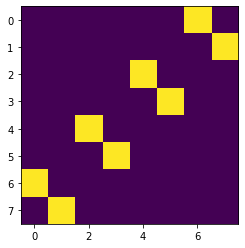

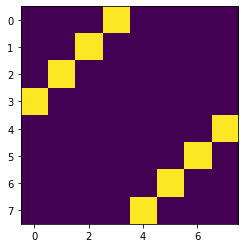

In [ ]:
plt.imshow(np.abs(A))
plt.show()

plt.imshow(np.abs(B))
plt.show()

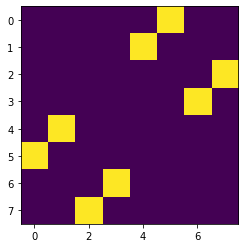

In [ ]:
plt.imshow(np.abs(A@B - B@A))

In [ ]:
H=mpnum.random_mpo(sites=N, ldim=d, rank=4, hermitian=True)

In [ ]:
#Loading Ground State
gs=[]
with open(filepath+'gs.pkl', 'rb') as input:
  for i in range(N):
    gs.append(pickle.load(input))

gs=mpnum.MPArray(gs)

#Loading Hamiltonian
H=[]
with open(filepath+'H.pkl', 'rb') as input:
  for i in range(N):
    H.append(pickle.load(input))

H=mpnum.MPArray(H)

$O(N_{sweep} N T_{SVD}(dm))$

In [ ]:
eigs = ft.partial(eigsh, k=1, tol=1e-6, which='SA')
tm=time.time()
E0,gs=mpnum.linalg.eig(H,num_sweeps=4,startvec_rank=min(16,max_rank),eigs=eigs)
print(time.time()-tm, E0)

In [ ]:
#Saving Ground State
gs_lt=mpa_to_lt(gs)

with open(filepath+'gs.pkl', 'wb') as output:
  for i in range(N):
    pickle.dump(gs_lt[i], output, pickle.HIGHEST_PROTOCOL)

#Saving Hamiltonian
H_lt=mpa_to_lt(H)

with open(filepath+'H.pkl', 'wb') as output:
  for i in range(N):
    pickle.dump(H_lt[i], output, pickle.HIGHEST_PROTOCOL)

### SVD

In [ ]:
def Entangle(mpa,method='mps'):
  N=len(mpa)
  rank=max(mpa.ranks)

  if method=='full':
    #Warning: Full method can lead to memory run-offs. 
    psi=mpa.to_array()

  else:
    mpa.canonicalize(left=N//2-1, right=N//2)
    #print(mpa.canonical_form)

    M=mpa.lt
    psi=np.tensordot(M[N//2-1],M[N//2],axes=(-1,0))
  
  psi_shape=int(np.sqrt(psi.size))
  psi=np.reshape(psi,(psi_shape,psi_shape))
  
  S=la.svd(psi,compute_uv=False)
  #print(la.norm(S))
  S=S/la.norm(S)

  S2=np.abs(S)
  EE=-np.sum(S2**2*np.log2(S2**2+1e-32)) #Add eps=1e-32 to avoid log(0) error.
  return EE, S

In [ ]:
tm=time.time()
EE,S=Entangle(gs)  
print(time.time()-tm)

0.0782923698425293


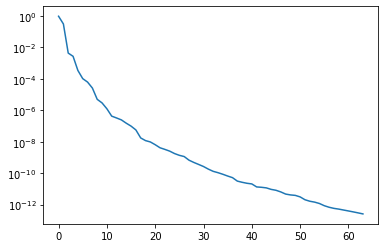

In [ ]:
plt.semilogy(S[:64])

### AGSP

In [ ]:
loc_op=mpnum.random_mps(sites=2, ldim=(d,d), rank=4) 

DL_even = mpnum.factory.eye(sites=1, ldim=d)
DL_odd = loc_op  

for i in range(N//2-1):
  DL_odd = mpnum.chain([DL_odd, loc_op])
  DL_even = mpnum.chain([DL_even, loc_op])

DL_even=mpnum.chain([DL_even, mpnum.factory.eye(sites=1, ldim=d)])

A = mpnum.dot(DL_odd, DL_even)

In [ ]:
DL_even = mpnum.factory.eye(sites=1, ldim=d)
DL_odd = mpnum.random_mps(sites=2, ldim=(d,d), rank=4)
for i in range(N//2-1):
  DL_odd = mpnum.chain([DL_odd, mpnum.random_mps(sites=2, ldim=(d,d), rank=4)]) 
  DL_even = mpnum.chain([DL_even, mpnum.random_mps(sites=2, ldim=(d,d), rank=4)])

DL_even = mpnum.chain([DL_even, mpnum.factory.eye(sites=1, ldim=d)])

A = mpnum.dot(DL_odd, DL_even)

In [ ]:
loc_op=mpnum.random_mps(sites=3, ldim=(d,d), rank=4)

DL = [mpnum.factory.eye(sites=1, ldim=d), mpnum.factory.eye(sites=2, ldim=d), loc_op]

for i in range(N-3):
  if i%3==0: DL[0] = mpnum.chain([DL[0], loc_op])
  elif i%3==1: DL[1] = mpnum.chain([DL[1], loc_op])
  else: DL[2] = mpnum.chain([DL[2], loc_op])

for i in range(3):
  if len(DL[i])<N:
    DL[i] = mpnum.chain([DL[i], mpnum.factory.eye(sites=N-len(DL[i]), ldim=d)]) 

A = mpnum.dot(DL[0], DL[1])
A = mpnum.dot(A, DL[2])

In [ ]:
np.array(A.ranks)

array([ 4, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,  4])

In [ ]:
EE1,S1=Entangle(A,method='mpo')
#EE1,S1=Entangle(loc_op,method='full')

NameError: ignored

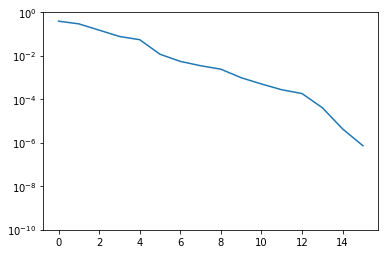

In [ ]:
plt.semilogy(S1[:16]**2)
plt.ylim((1e-10,1))
plt.show()

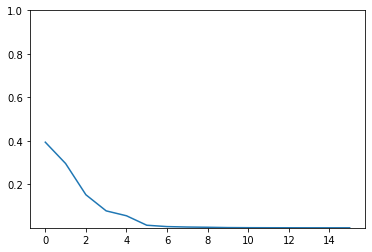

In [ ]:
plt.plot(S1[:16]**2)
plt.ylim((1e-10,1))
plt.show()

In [ ]:
(S1[:4]**2).round(3)

array([0.394, 0.296, 0.152, 0.078])

### Operation

Space Complexity:
* MPS: $O(N m_S^2 \ m_O^2 \ d)$
* SVD: $O(d^N)$

Run-Time Analysis:
* $T_{SVD} = O(N d m^3)$ or $O(m^2 d^N + d^{3N/2})$ or $O(m^3 d^s + m^2 d^{3s/2})$ $\quad$ (numpy)
* $T_{eval} = O(N \ m_S^3 \ m_O \ d^2)$ $\quad$ ($m_S > m_O$)
* $T_{norm} = O(N m_S^3 \ d)$
* $T_{dot}(m_{S1}, m_{S2}) = O(N m_{S1}^2 \ m_{S2} \ d)$ $\quad$ ($m_{S1} > m_{S2}$)
* $T_{overlap}(m_{S1}, m_O, m_{S2}) = O(N \ m_{S1}^2 m_{S2} \ m_O \ d)$ $\quad$ ($m_{S1} > m_{S2} > d*m_O$)
* $T_{compress} = O(N_{sweep}) * T_{dot}(m_S \ m_O,\ m_S)$
* $T_{total} = O(N_{iter} \ (T_{SVD} + T_{eval} + T_{dot} + T_{compress})) \approx O(N_{iter} N_{sweep} N m_S^3 m_O^3 d)$

In [ ]:
rng = np.random.RandomState(seed=42)
rank=1
mpa = mpnum.random_mps(sites=N, ldim=d, rank=rank, randstate=rng)

In [ ]:
Energy_hist=[]
Overlap_hist=[]
Comp_overlap_hist=[]
EE_hist=[]
S_hist=np.zeros((d*max_rank,0))

In [ ]:
'''
for i in range(312):
  #Loading MPS
  mpa = []
  with open(filepath+'mpa/mpa'+str(i)+'.pkl', 'rb') as input:
    for i in range(N):
      mpa.append(pickle.load(input))
  mpa=mpnum.MPArray(mpa)

  EE,S=Entangle(mpa)

  EE_hist.append(EE)
  S.resize(d*max_rank)
  S_hist=np.concatenate((S_hist, S.reshape(-1,1)), axis=1)

  Energy_hist.append(mpnum.sandwich(H,mpa))
  Overlap_hist.append(mpnum.inner(gs,mpa))
'''

"\nfor i in range(312):\n  #Loading MPS\n  mpa = []\n  with open(filepath+'mpa/mpa'+str(i)+'.pkl', 'rb') as input:\n    for i in range(N):\n      mpa.append(pickle.load(input))\n  mpa=mpnum.MPArray(mpa)\n\n  EE,S=Entangle(mpa)\n\n  EE_hist.append(EE)\n  S.resize(d*max_rank)\n  S_hist=np.concatenate((S_hist, S.reshape(-1,1)), axis=1)\n\n  Energy_hist.append(mpnum.sandwich(H,mpa))\n  Overlap_hist.append(mpnum.inner(gs,mpa))\n"

In [ ]:
for i in range(4):
  '''
  #Saving MPS
  mpa_lt=mpa_to_lt(mpa)
  with open(filepath+'mpa/mpa'+str(i)+'.pkl', 'wb') as output:
    for j in range(N):
      pickle.dump(mpa_lt[j], output, pickle.HIGHEST_PROTOCOL)
  '''

  tm=time.time()
  EE,S=Entangle(mpa)

  EE_hist.append(EE)
  S.resize(d*max_rank)
  S_hist=np.concatenate((S_hist, S.reshape(-1,1)), axis=1)

  #Energy_hist.append(mpnum.sandwich(H,mpa))
  #Overlap_hist.append(mpnum.inner(gs,mpa))

  mpa = mpnum.dot(A,mpa)
  mpa=mpa/mpnum.norm(mpa)

  comp_overlap = mpa.compress(method='var',
                    rank=min(max(mpa.ranks), max_rank),
                    num_sweeps=4)
  
  print("Epoch: ",i+1,"\t Rank: ",np.count_nonzero(S_hist[:,i]>1e-15, axis=0), "\t Time: ",np.round(time.time()-tm,3))
  Comp_overlap_hist.append(comp_overlap)

Epoch:  1 	 Rank:  1 	 Time:  0.577
Epoch:  2 	 Rank:  8 	 Time:  17.086
Epoch:  3 	 Rank:  64 	 Time:  428.573
Epoch:  4 	 Rank:  64 	 Time:  427.505


In [ ]:
np.array(mpa.ranks)

array([ 2,  4,  8, 16, 32, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
       64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
       64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
       64, 64, 64, 64, 64, 64, 64, 32, 16,  8,  4,  2])

### Plots

In [ ]:
x,y,z=S_hist[:3,1:]

x=np.log2(x)
y=np.log2(y)
z=np.log2(z)

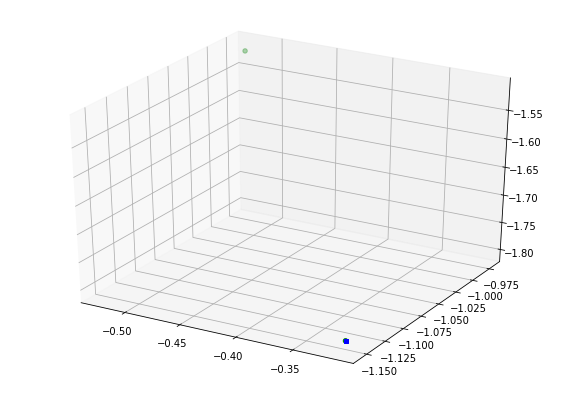

In [ ]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(x[1:], y[1:], z[1:], color = "green")
ax.scatter3D(x[1], y[1], z[1], color = "blue",marker='s')
#ax.scatter3D(np.log2(S[0]),np.log2(S[1]),np.log2(S[2]), color = "r")

plt.show()

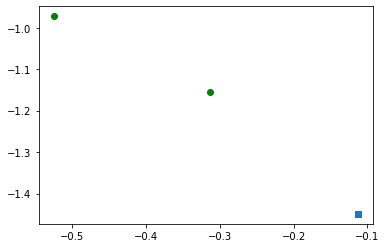

In [ ]:
plt.scatter(x[:],y[:],c='green')
plt.scatter(x[0],y[0],marker='s')
#plt.scatter(np.log2(S[0]),np.log2(S[1]),marker='*',c='r')

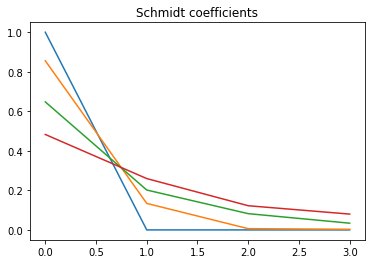

In [ ]:
plt.title('Schmidt coefficients')
plt.plot(np.arange(4),S_hist[:4,:]**2)
plt.show()

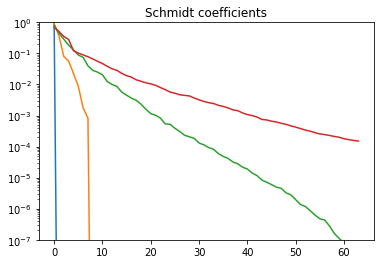

In [ ]:
plt.semilogy(S_hist[:max_rank,:6])
plt.title('Schmidt coefficients')
plt.ylim((1e-7,1))
#plt.legend(np.arange(6,12))
plt.show()

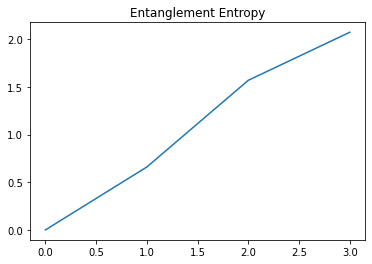

In [ ]:
plt.plot(EE_hist)
plt.title('Entanglement Entropy')
#plt.hlines(EE,0,len(EE_hist)-1,colors='r',linestyles='dashed')
plt.show()

In [ ]:
ER=np.count_nonzero(S_hist>1e-16, axis=0)

Text(0.5, 1.0, 'Entanglement Rank')

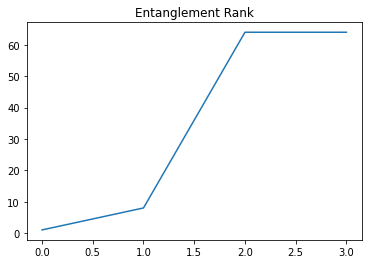

In [ ]:
plt.plot(ER)
plt.title('Entanglement Rank')

### Fitting

In [ ]:
def f(x,a,b):
  return (x*d)**(a*np.sqrt(x)+b)

In [ ]:
x=np.arange(1,12)
y=ER[1:9]   #[3,  5,  9,  13,  20,  28,  39,  53,  70,  92, 117] #
res=curve_fit(f, x, y, [1,0])

In [ ]:
a,b=res[0]
a,b

In [ ]:
x2=np.arange(1,12)
y2=[3,  5,  9,  13,  20,  28,  39,  53,  70,  92, 117] #ER[1:13]
plt.plot(x2,f(x2,a,b))
plt.plot(x2,y2)
plt.xlabel('Iteration (l)')
plt.ylabel('Entanglement Rank')
plt.show()

plt.figure()
plt.plot(x2,np.log2(f(x2,a,b)))
plt.plot(x2,np.log2(y2))
plt.xlabel('Iteration (l)')
plt.ylabel('$log_2(ER)$')
plt.show()

In [ ]:
def f(x,a,b,c):
  return a*np.log10(np.abs(b*x+c))

In [ ]:
x=np.arange(32)
y=np.log10(S[:32])
res=curve_fit(f,x,y,[-10,1,1])
a,b,c=res[0]
a,b,c

In [ ]:
plt.plot(x,f(x,a,b,c))
plt.plot(x,y)
plt.show()

In [ ]:
plt.plot(np.sqrt(x),-1.85*np.sqrt(x))
plt.plot(np.sqrt(x),y)
plt.show()

In [ ]:
plt.plot(np.log10(x),y)
plt.show()